In [1]:
%reload_ext autoreload
%autoreload 2

# Clasificación de textos
En este caso, se busca clasificar texto proveniente de recomendaciones (tweets) sobre ciertos artículos, que a simple vista parecen pertenecer al ámbito de la moda. Para llevar a cabo esta clasificación, se realizará un preprocesamiento exhaustivo del texto, que incluye la eliminación de signos de puntuación, la unión de negaciones y la lematización de las palabras. Además, el dataset presenta un desafío adicional, ya que la clase positiva es mayoritaria, a diferencia de lo habitual donde suele ser minoritaria.

Para la clasificación de estos textos, se implementará un modelo con una arquitectura inicial predefinida, la cual se ajustará en función de los resultados obtenidos. El objetivo es encontrar un equilibrio adecuado entre la complejidad de la red y el error de clasificación, dado que redes excesivamente complejas pueden conducir a problemas de overfitting.

Una vez que el modelo esté entrenado y se haya seleccionado la métrica de evaluación (F1 score), junto con la validación de los hiperparámetros, se utilizará para clasificar los datos del archivo `new_data.txt`. A continuación, se procede a la carga de las librerías necesarias.

NOTA: El mismo ejercicio ha sido resuelto en el notebook **02_text_classif_pre_trained** con el modelo pre-entrenado GloVe con lingitud 100. En ese caso aunque las métricas son similares la principal diferencia es que mejora la matriz de confusión tanto en faslos positivos como negativos por lo que mejora la calidad de las prediciones del modelo. No se duplican las explicaciones en cada notebook ya que los pasos y modelo de red neuronal son análogos salvo en la utilización de embeddings pre-entrenados.

In [2]:
# Standard library imports
from pathlib import Path

# Related third-party imports
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score
)
from sklearn.model_selection import train_test_split
from keras_tuner import Objective, BayesianOptimization
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, GRU
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from focal_loss import BinaryFocalLoss

# Local application/library-specific imports
from text_classification.paths import DATA_DIR, MODELS_DIR
import text_classification.config as cfg
from text_classification.analytics import clean_text
from text_classification.plots import (
    plot_training_history, plot_f1_scores_vs_thresholds, plot_confusion_matrix, plot_roc_curve
)

# Inline plotting for Jupyter notebooks
%matplotlib inline

Se descargan los stopwords y los datos de lemas para la limpieza del texto. En este caso se eliminan los stopwords y se procede a la lematización en vez de al tokenización de las palabras ya que permite recoger mejor el sentimiento de las frases.

In [36]:
# # Download stopwords and lemmatizer data if necessary
# nltk.download('stopwords')
# nltk.download('wordnet')

Se comprueba que se pueden utilizar los recursos de GPU para acelerar el proceso.

In [37]:
# Check if MPS is available
if tf.config.list_physical_devices('GPU'):
    print("MPS backend is available and will be used.")
else:
    print("MPS backend is not available. Using CPU instead.")

MPS backend is available and will be used.


Se definen las constantes del problema, el máximo de palabras por texto que se empleará en la fase de padding, las máxima frecuencia de palabras o vocabularia así como la longitud máxima del embedding.

In [3]:
# Use constants from config.py
max_length = cfg.MAX_WORDS_PER_TEXT # 60 
vocab_size = cfg.MAX_FREQ_WORDS # 2500
embedding_dim = cfg.MAX_EMBEDDINGS_DIM # 100

Se inicializa el tokenizador y se cargan los datos necesarios para llevar a cabo la clasificación. El dataset new_data no contiene información relativa a la clasificacion de los textos. Dicha clasificación será realizada con el modelo una vez entrenado y validado.

In [4]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)

In [5]:
# Load data 
data_files = ['historical_data.csv', 'new_data.csv']

# Load new data
data, new_data = [pd.read_csv(DATA_DIR / file) for file in data_files]

Se muewtran las primeras lineas del dataset y se ve que se compone de dos columnas uno con texto y la otra con la recomendación siendo 1 positivo y 0 negativo.

In [6]:
# train overview
data.head()

,Review.Text,Recommended.IND
0,This top runs large. i had no problem sizing d...,1
1,"I love the black and pale pink of this dress, ...",1
2,"Great quality, beautiful print, definitely a s...",1
3,I bought these in a few different colors becau...,1
4,This dress fits well and the material allows f...,1


Se observa que no existen duplicados ni valores faltantes en cada una de las columnas. Asimismo, se puede ver como la clase positiva es un 82% del dataset mientras que la negativa es únicamente el 18% aproximadamente.

In [7]:
# Basic information about the dataset
data.info()

# Check the proportions of the target variable
data['Recommended.IND'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review.Text      4500 non-null   object
 1   Recommended.IND  4500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.4+ KB


Recommended.IND
1    0.820889
0    0.179111
Name: proportion, dtype: float64

Se ha procedido a la recopilación y suo de una lista extensa de palabras negativas en inglés que pueden ir acompañadas de otras palabras cambiando el sentimiento de la frase.

In [8]:
# Load from the text file negations
with open(Path(DATA_DIR / 'negations.txt'), 'r') as file:
    negations = [line.strip() for line in file]

Se procede al preprocesado básico tanto del dataset de entrenamiento como del dataset final.

In [9]:
# Rename the columns, apply the cleaning function, and calculate character counts
data = (
    data
    .rename(columns={'Recommended.IND': 'recommended', 'Review.Text': 'review'})
    .assign(
        cleaned_review=lambda df: df['review'].apply(lambda x: clean_text(x, negations)),
        review_char_count=lambda df: df['review'].str.len(),
        cleaned_review_char_count=lambda df: df['cleaned_review'].str.len()
    )
)

# Apply the cleaning function and calculate character counts for new_data
new_data = (
    new_data
    .assign(
        cleaned_review=lambda df: df['Review.Text'].apply(lambda x: clean_text(x, negations)),
    )
)

# Print the first few rows to verify the new columns
data.head()

,review,recommended,cleaned_review,review_char_count,cleaned_review_char_count
0,This top runs large. i had no problem sizing d...,1,top run large not_problem not_sizing one size ...,502,339
1,"I love the black and pale pink of this dress, ...",1,love black pale pink dress contrasting fabric ...,500,293
2,"Great quality, beautiful print, definitely a s...",1,great quality beautiful print definitely steal...,148,118
3,I bought these in a few different colors becau...,1,bought different color comfortable perfect sum...,200,107
4,This dress fits well and the material allows f...,1,dress fit well material allows hiding lump bum...,427,272


Se observa una disminución significativa en el número de tokens tras la limpieza inicial del texto. Esta limpieza consiste en eliminar los signos de puntuación, convertir todas las letras a minúsculas, eliminar palabras comunes (stopwords) y eliminar caracteres repetidos. Estas operaciones son fundamentales para reducir el ruido en los datos y mejorar la calidad de las representaciones textuales, asegurando que el modelo se centre en las palabras más relevantes.

In [10]:
# Define feature matrix X and target variable y
X = data.drop(columns=['recommended', 'review', 'review_char_count', 'cleaned_review_char_count'])
y = data['recommended']

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X['cleaned_review'].tolist(), 
    y, 
    test_size=0.20, 
    stratify=y,
    random_state=123
)

Una vez dividido el conjunto de datos en entrenamiento y validación, se procede a la lematización de las palabras, lo que ayuda a reducir las palabras a su forma base o raíz. Este paso se realiza después de la separación en ambos conjuntos para evitar "data leakage", es decir, que el modelo tenga acceso a información del conjunto de validación durante el entrenamiento, lo que podría sesgar los resultados.

Se utiliza un tokenizer para transformar los textos en secuencias numéricas. El mismo se ajusta únicamente en el conjunto de entrenamiento, lo que significa que aprende el vocabulario y asigna un número entero a cada palabra presente en los textos de entrenamiento. Posteriormente, tanto el conjunto de entrenamiento como el de validación se convierten en secuencias de enteros utilizando las palabras previamente tokenizadas.

Para asegurar que todas las secuencias tengan la misma longitud, se ajustan todas las secuencias al mismo número de palabras (en este caso, 60). Si una secuencia es más corta, se rellena con ceros al final. Este formato consistente permite que las entradas tengan la misma forma para ser procesadas adecuadamente en la red neuronal, y las secuencias resultantes son utilizadas para formar embeddings densos que alimentan el modelo.

In [13]:
# Fit tokenizer on the list of cleaned reviews
tokenizer.fit_on_texts(X_train)  

# Convert the training and validation sets to sequences of integers and pad them
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train),
                             maxlen=max_length, 
                             padding='post')
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val),
                           maxlen=max_length,
                            padding='post')

Debido al desbalanceo presente en el dataset, se calcula una serie de alternativas de pesos para cada una de las clases. Estas alternativas buscan mitigar la diferencia de frecuencias con la que aparecen las clases en los datos, asignando mayor peso a la clase minoritaria para que tenga más relevancia durante el entrenamiento del modelo. De este modo, el modelo puede aprender mejor a clasificar correctamente tanto la clase mayoritaria como la minoritaria, evitando que el desbalanceo sesgue las predicciones hacia la clase más frecuente. Este enfoque ayuda a mejorar el rendimiento en problemas con clases desbalanceadas y garantiza que el modelo preste suficiente atención a la clase menos representada.

In [47]:
# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Store in a dictionary to fit the model
class_weight_dict = dict(enumerate(class_weights))

# Define additional class weight options
class_weight_options = [
    class_weight_dict,
    {0: 10.0, 1: 0.2},
    {0: 4.0, 1: 0.5},
    {0: 5.0, 1: 1.22}
]

Aunque se comienza con los datos calciulados directamente de la frecuencia existente en el dataset dicha diferencia se hace todavía mayor poniendo más relevancia en la clase minoritaria, en este caos l clase negativa. Se procede a definir el modelo de red neuronal asi como el método de tuneado de los hiperparámetros de la red.

Este modelo se basa en una combinación de capas convolucionales, LSTM y GRU bidireccionales para clasificar texto binariamente. Primero, utiliza una capa de embedding para convertir las palabras en vectores densos, seguida de una capa de convolución 1D para extraer características locales con regularización L2 y un pool de max-pooling.

Se añaden capas LSTM y GRU bidireccional para capturar dependencias temporales complejas en ambas direcciones así como secuencias a largo plazo. Posteriormente, una capa densa con regularización L2 y dropout mitiga el sobreajuste. Finalmente, se utiliza una capa de salida con activación sigmoide para predecir la clase binaria.

El modelo emplea diferentes optimizadores y pérdida focalizadas para manejar desequilibrios de clase, junto con métricas de rendimiento como precisión, recall, AUC y F1 Score para evaluación.

In [48]:
# Build model function for Bayesian Optimization
def build_model(hp):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=cfg.MAX_FREQ_WORDS,  # Maximum number of words in the vocabulary
                        output_dim=cfg.MAX_EMBEDDINGS_DIM,  # Dimension of the dense embedding
                        trainable=True))

    # Choose weight initializer
    weight_initializer = hp.Choice('weight_initializer', values=['he_normal', 'glorot_uniform', 'lecun_normal'])

    # 1D Convolutional Layer with L2 regularization and padding
    model.add(Conv1D(filters=hp.Int('conv_filters', min_value=16, max_value=264, step=16),
                     kernel_size=hp.Choice('conv_kernel_size', values=[3, 5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                     kernel_initializer=weight_initializer))
    model.add(MaxPooling1D(pool_size=2))

    # LSTM layer with L2 regularization
    model.add(LSTM(units=hp.Int('lstm_units', min_value=16, max_value=264, step=16),
                   return_sequences=True,
                   kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                   kernel_initializer=weight_initializer))

    # Bidirectional GRU layer
    model.add(Bidirectional(GRU(units=hp.Int('gru_units', min_value=16, max_value=264, step=16),
                                return_sequences=False)))  # Change return_sequences based on architecture needs

    # Dense layer with L2 regularization
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=264, step=16),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                    kernel_initializer=weight_initializer))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)))

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid', kernel_initializer=weight_initializer))

    # Choose optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    optimizer_instance = {
        'adam': Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        'rmsprop': RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        'sgd': SGD(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    }[optimizer_choice]

    # Dynamically select class weights
    class_weight_index = hp.Choice('class_weight_index', [0, 1, 2, 3])
    class_weight = class_weight_options[class_weight_index]

    # Compile the model
    model.compile(optimizer=optimizer_instance,
                  loss=BinaryFocalLoss(gamma=hp.Float('gamma', min_value=0.5, max_value=5.0, step=0.5)),
                  metrics=[F1Score(name='f1_score', threshold=hp.Float('thresholds', min_value=0.1, max_value=0.9, step=0.1)),
                           'accuracy',
                           Precision(),
                           Recall(),
                           AUC()])

    return model

La red LSTM se utiliza para capturar las relaciones temporales y las dependencias a largo plazo en la secuencia de texto. La capa LSTM procesa las secuencias de manera unidireccional, lo que significa que analiza el texto desde el inicio hasta el final. Además, se aplica una regularización L2 en los pesos para evitar el sobreajuste.

Se incluye a su salida un acapa GRU (Gated Recurrent Unit) bidireccional, que mejora la capacidad de la red para entender contextos complejos al procesar la secuencia en ambas direcciones. Las redes GRU, a diferencia de las LSTM, son más simples y tienen menos parámetros, lo que las hace más eficientes sin perder mucha precisión. Esta capa captura tanto la información anterior como la futura en la secuencia. El número de unidades en esta capa también es configurable permitiendo así que el modelo se adapte a las características específicas de los datos.

Ambas capas ayudan a mejorar el modelado de secuencias complejas en el texto, siendo claves para tareas de clasificación de texto que dependen de contextos largos o donde el orden de las palabras es importante.

Una vez definido el espacio de búsqueda en la definición de hiperparámetros del modelo de clasificación de textos, se emplará un tuner basado en la optimización bayesiana para ajustar los mismo. El tuner se inicializa definiendo la arquitectura del modelo, y optimiza el hiperparámetro objetivo, que en este caso es el F1 Score en el conjunto de validación (val_f1_score), maximizando su valor. Se establecen un número pruebas de 10 y 10 ejecuciones por prueba.

La optimización bayesiana se elige porque, a diferencia de métodos de búsqueda aleatoria o en cuadrícula, realiza una exploración más eficiente del espacio de hiperparámetros al crear un modelo probabilístico de las posibles configuraciones. Esto permite encontrar combinaciones óptimas de hiperparámetros con menos evaluaciones, lo cual es útil para acelerar la búsqueda de hiperparámetros reduciendo el espacio a aquellos definidos inicialmente.

In [49]:
# Initialize the BayesianOptimization tuner
tuner = BayesianOptimization(
    build_model,
    objective=Objective('val_f1_score', direction='max'),
    max_trials=cfg.MAX_TRIALS,
    executions_per_trial=cfg.EXECUTIONS_PER_TRIAL,
    directory=Path(MODELS_DIR) / 'tuner_2',
    project_name='bayes_opt'
)

# Display the search space summary
tuner.search_space_summary()

Reloading Tuner from /Users/borja/Documents/Somniumrema/projects/ml/text_classification/models/tuner_2/bayes_opt/tuner0.json
Search space summary
Default search space size: 13
weight_initializer (Choice)
{'default': 'he_normal', 'conditions': [], 'values': ['he_normal', 'glorot_uniform', 'lecun_normal'], 'ordered': False}
conv_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 264, 'step': 16, 'sampling': 'linear'}
conv_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
l2_lambda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 264, 'step': 16, 'sampling': 'linear'}
gru_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 264, 'step': 16, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 264,

El espacio de búsqueda se bastande ampli conteniendo 13 hiperparámetros_

- `weight_initializer`: Permite seleccionar entre tres inicializadores de pesos ('he_normal', 'glorot_uniform', 'lecun_normal') para las capas del modelo.
- `conv_filters`: Número de filtros en la capa de convolución, que varía entre 16 y 264, en pasos de 16.
- `conv_kernel_size`: Tamaño del kernel de la capa de convolución, con opciones de 3 o 5.
- `l2_lambda`: Coeficiente de regularización L2, que varía en un rango logarítmico entre 1e-05 y 0.01, para controlar el overfitting.
- `lstm_units`: Número de unidades en la capa LSTM, con un rango entre 16 y 264 en pasos de 16.
- `gru_units`: Número de unidades en la capa GRU bidireccional, también con un rango entre 16 y 264 en pasos de 16.
- `dense_units`: Unidades en la capa densa, con un rango similar de 16 a 264 en pasos de 16.
- `dropout_rate`: Tasa de dropout, que varía entre 0.2 y 0.7 en pasos de 0.1, para mitigar el sobreajuste.
- `optimizer`: El optimizador del modelo, con opciones de 'adam', 'rmsprop' y 'sgd'.
- `learning_rate`: Tasa de aprendizaje, que varía en un rango logarítmico entre 1e-05 y 0.01.
- `class_weight_index`: Índice de la estrategia de ponderación de clases para mitigar el desbalance entre clases.
- `gamma`: Parámetro gamma de la función de pérdida focal, con valores entre 0.5 y 5.0 en pasos de 0.5, que ayuda a penalizar más las clases minoritarias.
- `thresholds`: Umbral de decisión para la clasificación, que varía entre 0.1 y 0.9 en pasos de 0.1, ajustando cuándo una predicción se considera positiva o negativa.

In [50]:
# Use the tuner to search the hyperparameter space
tuner.search(
    X_train_pad, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_pad, y_val),
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=cfg.PATIENCE,
            restore_best_weights=True
        )
    ]
)

Se busc la mejor configuración de hiperparámetros para el modelo de clasificación. Para ello y despues de realizar numerosas prubeas el valor de batch_size que da mejores resultados es 32, habiendose probado valores de 32, 64, 128 y 256.

In [51]:
# Get the best hyperparameters after tuning
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best class weight
best_class_weight = class_weight_options[best_hps['class_weight_index']]

print(f"The best class weight is: {best_class_weight}")

The best class weight is: {0: 10.0, 1: 0.2}


Los pesos utilizados para mitigar la diferencia de frecuencias entre las clases es 10/0.2 superior a la calculada inicialmente como inversa de la frecuencia de aparición. Una vez obtenidos los hiperparámetros del model, se procede a su ajuste y entrenamiento posterior. En primer lugar se vuelve a asegurar que los valores de etiquetado en los sets de validación y entrenamiento tengan el formato correcto.

In [52]:
# Ensure the target variable is in the correct format
y_train = np.array(y_train).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)

# Build the model using the best hyperparameters
model = build_model(best_hps)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Se procede a montar la arquitectura relativa a los mejores hiperparámetros encontrados en el espacio de búsqueda inicial. y con ello se entrena el modelo. Se da mayor tiempo en el entrenamiento para realizar un early stopping. La razón para ello es que el número de epochs es bajo y por lo tanto requirer entrenarlo al menos dos veces siendo necesario en la segunda dar un poco de espacio al modelo para el final den entrenamiento.

In [81]:
# Train the model with the best hyperparameters and appropriate class weights
history = model.fit(
    X_train_pad, y_train,
    batch_size=128,
    epochs=40,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping]
)

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 348ms/step - accuracy: 0.9580 - auc: 0.9821 - f1_score: 0.9731 - loss: 0.1013 - precision: 0.9783 - recall: 0.9697 - val_accuracy: 0.8711 - val_auc: 0.8662 - val_f1_score: 0.9243 - val_loss: 0.3453 - val_precision: 0.9083 - val_recall: 0.9378
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - accuracy: 0.9830 - auc: 0.9897 - f1_score: 0.9875 - loss: 0.0657 - precision: 0.9886 - recall: 0.9907 - val_accuracy: 0.8600 - val_auc: 0.8584 - val_f1_score: 0.9175 - val_loss: 0.3981 - val_precision: 0.8671 - val_recall: 0.9797
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - accuracy: 0.9935 - auc: 0.9976 - f1_score: 0.9928 - loss: 0.0458 - precision: 0.9947 - recall: 0.9973 - val_accuracy: 0.8044 - val_auc: 0.8623 - val_f1_score: 0.8828 - val_loss: 0.5823 - val_precision: 0.9433 - val_recall: 0.8106
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.9834 - auc: 0.9970 - f1_score: 0.9896 - loss: 0.0544 - precision: 0.9919 - recall

Se entrena el modelo consiguiendo valores de fi en validación del 0.9233. En este caso han sido necesarios 25 epochs para logar dichos valor. Se puede verc omo los valores de precisión y recall se encuentran en valores altos. Se muestra la arquitectuea del modelo entrendado

In [82]:
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 60, 100)        │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 48)         │        24,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 112)        │        72,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 96)             │        46,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 798,212 (3.04 MB)

 Trainable params: 399,105 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 399,107 (1.52 MB)

Al haberse discutido en detalle la arquitectura anteriormente, únicamente cabe destacar los valores finales elegidos. En la capa de embeddings se cumple con las restricciones exigidas de 60 palabras y embeddigns de tamaño 100. Asimomsp se pbnserva que las redes son relativamente pequeñas hasta la bi-GRU la cual es por lo menos 30 veces mayor que las anteriores. En el caso de las densas se reduce a 64 a mendida que se aproxima a la salida. En este caso, se suponía a priori que sería necesario una red neuronal más compleja. Aunque los gráficos de entrenamiento de validación y loss únicamente recogen los últimos valores de entrenamitno se puede observar como el valor de f1 en el entrenamiento ya se encuentra en valores unitarios y elo valor de validación se encuentra poir debajo pero muy próximo. En repetidas pruebas se ha podido comprobar que incrementar los epochs no mejora el secoring en validación.

In [83]:
# Plot the training history
plot_training_history(history)

En lo que respecta a la función de loss, se puede observar que la misma en validción llega a una fase de plateau ientras que la de entrenamiento sigue reduciendose.

In [84]:
# Serialize the trained model
model.save(MODELS_DIR / 'lstm4.keras') 

In [14]:
# Load the saved model with custom objects
tc_model = tf.keras.models.load_model(
    MODELS_DIR / 'lstm4.keras')

# Predict probabilities for the validation set
y_pred_prob = tc_model.predict(X_val_pad)

 1/29 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step

2024-09-11 22:35:07.561284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


Una ve serializado el modelo se reliazan las predicciones y se ajusta el threshold de respuesta para optimizar la calidad del mismo.

In [15]:
# Define a range of threshold values and calculate F1 scores
thresholds = np.arange(cfg.MIN_THRESHOLD, cfg.MAX_THRESHOLD, cfg.STEP)
f1_scores = [f1_score(y_val, (y_pred_prob >= t).astype(int)) for t in thresholds]

# Find the best threshold
best_threshold = thresholds[np.argmax(f1_scores)]

Se observa como para valores de 0.4 se optimiza ligeramente el valor de f1. Este segunod ajuste de esta métrica es un ajuste fino en todos los casos ya que no se realizan grandes cambios en el valor de la misma.

In [16]:
# Plot F1 scores vs. thresholds
plot_f1_scores_vs_thresholds(thresholds, f1_scores, best_threshold)

Se procede a realizar las predicciones de clase basadas en las predicciones de probabilidad y threshold.

In [88]:
# Binary classification using the best threshold
y_pred = (y_pred_prob > best_threshold).astype(int)

In [89]:
# Print the classification report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.52      0.59       161
           1       0.90      0.95      0.92       739

    accuracy                           0.87       900
   macro avg       0.80      0.73      0.76       900
weighted avg       0.86      0.87      0.86       900



Los resultados muestran como para la clase 0 (la minoritaria), la precisión es de 0.69 indicando que este porcentaje de las predicciones de clase 0 fueron correctas, pero con un recall de 0.52, lo que sugiere que el modelo solo identificó correctamente menor cantidad de casos reales de la clase cero. Esto lleva a un F1-score de 0.59, que es un equilibrio entre precisión y recall.

Por otro lado, la clase 1 (la mayoritaria) tiene una precisión de 0.90 y un recall de 0.95, lo que se traduce en un F1-score de 0.92, lo que refleja un mejor rendimiento en esa clase. La exactitud general del modelo es del 87%. El promedio macro, que da igual peso a ambas clases, muestra una F1 de 0.76, mientras que el promedio ponderado, que tiene en cuenta el desequilibrio de clases, es de 0.86. Esto indica que el modelo está sesgado hacia la clase mayoritaria aunque mantiene un rendimiento aceptable.

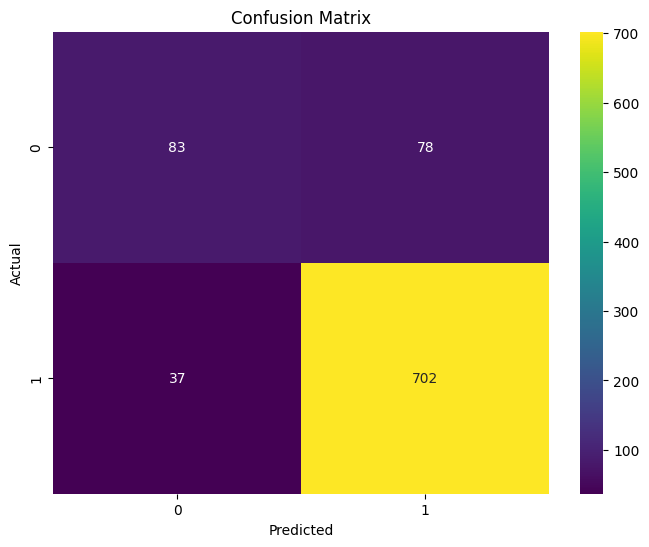

In [90]:
# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(conf_matrix)

Se observa en la matriz de confusión el desequilibrio entre ambas clases. En el caso de la clae positiva, mayoritaria debido al gran número de observaciones de la misma, el número de falsos positivos se traduce en un número menor (por denominador). En el caso de la clase negativa se observa que los casos de falsos negativos son significativamente mayores que los falsos positivos.

In [77]:
# Plot the ROC curve
plot_roc_curve(y_val, y_pred_prob)

Se puede observar el efecto del umbral elegido en los valores de falsos positivos vs positivos reales. Se observa que en el caso de valores superiores a 0.6 se ontienen un ACu superior al 95%. Una vez analizado el modelo y optimizado, se procede a realizar las prediciones de clase en los datos `new_data.txt`.

In [17]:
# Convert the new data to sequences, pad them, make predictions, and add the results to the DataFrame
new_data['recommended_predicted'] = (
    tc_model.predict(
        pad_sequences(
            tokenizer.texts_to_sequences(new_data['cleaned_review']),
            maxlen=max_length,
            padding='post'
        )
    ) > best_threshold
).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [19]:
# Prepare the new dataset by dropping the 'cleaned_review' column
new_data_prepared = new_data.drop(columns=['cleaned_review'])

# Save the new dataset with predictions
np.savetxt(DATA_DIR / 'new_data_w_preds.txt', new_data_prepared.values, fmt='%s', delimiter=',', header=','.join(new_data_prepared.columns), comments='')

In [80]:
# Clear the TensorFlow Keras session
tf.keras.backend.clear_session()